In [1]:
import lightgbm as lgb
from data_pipeline import data_transform_pipeline, cap_sales
import pandas as pd
from sklearn.metrics import mean_squared_error
import re

data = pd.read_csv('data/train.csv')

train_data = data[data['date'] < '2017-08-01']
train_data = cap_sales(train_data, 6500)
test_data = data[data['date'] >= '2017-08-01']
test_data = cap_sales(test_data, 6500)

X_train = train_data
y_train = X_train.pop('sales')

X_test = test_data
y_test = X_test.pop('sales')

X_train = data_transform_pipeline.fit_transform(X_train)
X_test = data_transform_pipeline.transform(X_test)

c:\Users\tzbk\CODIGOS\python\machine_learning\time_series_ml_analysis\data_pipeline.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sales = df.sales.map(lambda x: x if x < cap else cap)


In [ ]:
model = lgb.LGBMRegressor(force_row_wise=True, n_estimators=600, learning_rate=0.1, num_leaves=150, subsample=0.8, colsample_bytree=0.8, max_depth=1000, random_state=42)

In [13]:
model.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 2974158, number of used features: 40
[LightGBM] [Info] Start training from score 337.277697


LGBMRegressor(colsample_bytree=0.8, force_row_wise=True, max_depth=1000,
              n_estimators=700, num_leaves=150, random_state=42, subsample=0.8)

In [5]:
# Obtain gain feature importance
gain_importance = model.feature_importances_

# Display feature importance with feature names
feature_names = X_train.columns
gain_importance_df = pd.DataFrame({'Feature': feature_names, 'Gain': gain_importance})
print(gain_importance_df.sort_values(by='Gain', ascending=False))

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [14]:
predictions = model.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, predictions)}")
print(f"ROOT of MSE: {mean_squared_error(y_test, predictions)**0.5}")

MSE: 422176.4451265208
ROOT of MSE: 649.7510639672096


In [3]:
model.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 3000888, number of used features: 40
[LightGBM] [Info] Start training from score 338.214939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMRegressor(colsample_bytree=0.8, force_row_wise=True, max_depth=10,
              n_estimators=500, num_leaves=100, random_state=42, subsample=0.8)

In [4]:
X_competition = pd.read_csv('data/test.csv')
competition_indexes = X_competition['id']
X_competition = data_transform_pipeline.transform(X_competition)
X_competition = X_competition.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
competition_prediction = model.predict(X_competition)
competition_prediction[competition_prediction < 0] = 0


In [48]:
pd.DataFrame({'id':competition_indexes, 
              'sales':competition_prediction }).to_csv('data/submission.csv', index=False)

LN approach

In [35]:
import numpy as np

y_train_log = np.log1p(y_train)

model.fit(X_train, y_train_log)
predictions_log = model.predict(X_test)
predictions = np.expm1(predictions_log)

print(f"MSE: {mean_squared_error(y_test, predictions)}")
print(f"ROOT of MSE: {mean_squared_error(y_test, predictions)**0.5}")



[LightGBM] [Info] Total Bins 593
[LightGBM] [Info] Number of data points in the train set: 2974158, number of used features: 40
[LightGBM] [Info] Start training from score 2.917812
MSE: 779427.0126501742
ROOT of MSE: 882.8516368281673


In [42]:
predictions_train = model.predict(X_train)
print(f"MSE: {mean_squared_error(y_train, predictions_train)}")
print(f"ROOT of MSE: {mean_squared_error(y_train, predictions_train)**0.5}")

MSE: 296602.7318815338
ROOT of MSE: 544.6124602701758


Linear model

In [4]:
from sklearn.linear_model import LinearRegression

# Create an instance of LinearRegression
linear_model = LinearRegression()

In [5]:
# Fit the model to your training data
linear_model.fit(X_train, y_train)

# Make predictions
predictions = linear_model.predict(X_test)

In [6]:
print(f"MSE: {mean_squared_error(y_test, predictions)}")
print(f"ROOT of MSE: {mean_squared_error(y_test, predictions)**0.5}")

MSE: 382741.3643089998
ROOT of MSE: 618.6609445479808


In [6]:
linear_model.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

competition_prediction_linear = linear_model.predict(X_competition)

competition_prediction_linear[competition_prediction_linear < 0] = 0

In [ ]:
pd.DataFrame({'id':competition_indexes, 
              'sales':competition_prediction }).to_csv('data/linear_submission.csv', index=False)

In [ ]:
X_competition

In [7]:
competition_prediction

array([8.16501585e-01, 0.00000000e+00, 1.25849533e+01, ...,
       1.19327193e+03, 7.47549445e+01, 2.52801040e+01])

In [8]:
competition_prediction_linear

array([   0.        ,    0.        ,    0.        , ..., 1231.93945312,
         18.70703125,   26.921875  ])

In [10]:
competition_prediction = (competition_prediction + competition_prediction_linear)/2

In [11]:
competition_prediction

array([4.08250792e-01, 0.00000000e+00, 6.29247667e+00, ...,
       1.21260569e+03, 4.67309879e+01, 2.61009895e+01])

In [12]:
pd.DataFrame({'id':competition_indexes, 
              'sales':competition_prediction }).to_csv('data/joined_submission.csv', index=False)

RNN With LSTM Approach

In [7]:
import torch
import torch.nn as nn
import numpy as np


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout= 0):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        # extract only the last time step
        # x = x[:, -1]
        x = self.linear(x)
        return x

# Configuración del modelo
input_size = 40
hidden_size = 64
num_layers = 2
output_size = 1
dropout = 0.1

# Crear una instancia del modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout).to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [8]:
# Convertir datos a tensores de PyTorch
# X_train_tensor = torch.tensor(X_train.values.astype(np.float32)).to(device)
# y_train_tensor = torch.from_numpy(y_train.values.astype(np.float32)).reshape(-1, 1).to(device)

X_train_tensor = torch.tensor(X_train.astype(np.float32)).to(device)
y_train_tensor = torch.from_numpy(y_train.values.astype(np.float32)).reshape(-1, 1).to(device)

In [9]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X_train_tensor, y_train_tensor)

Epoch [1/10], Loss: 1610281.8750
Epoch [2/10], Loss: 897346.0625
Epoch [3/10], Loss: 725242.1875
Epoch [4/10], Loss: 587253.9375
Epoch [5/10], Loss: 565377.5625
Epoch [6/10], Loss: 525224.5625
Epoch [7/10], Loss: 517183.7812
Epoch [8/10], Loss: 522585.5312
Epoch [9/10], Loss: 490125.0000
Epoch [10/10], Loss: 519202.1875


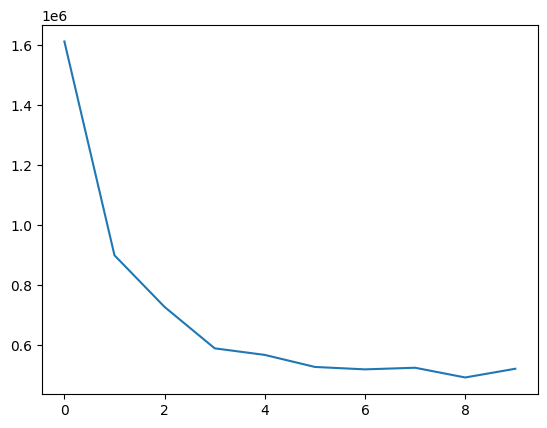

In [10]:
import matplotlib.pyplot as plt


batch_size = 5000
num_epochs = 10

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Entrenar el modelo
losses = []
epochs = []
x=0
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    epochs.append(epoch)
    losses.append(loss.item())
    # if (epoch+1) % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.plot(epochs, losses)
plt.show()

In [11]:
model.eval()
with torch.no_grad():
    predictions = model(torch.tensor(X_test.astype(np.float32)).to(device))

print(f"MSE: {mean_squared_error(y_test, predictions.cpu())}")
print(f"ROOT of MSE: {mean_squared_error(y_test, predictions.cpu())**0.5}")

MSE: 345187.72591946635
ROOT of MSE: 587.5267874058734


In [19]:
from data_pipeline import data_transform_pipeline, cap_sales
from lstm_model import model
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import numpy as np


data = pd.read_csv('data/train.csv')

X = data
y = X.pop('sales')

y_transformed = cap_sales(y, 7000)
X_transformed = data_transform_pipeline.fit_transform(X)



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

X_tensor = torch.tensor(X_transformed.astype(np.float32)).to(device)
y_tensor = torch.from_numpy(y_transformed.values.astype(np.float32)).reshape(-1, 1).to(device)

dataset = TensorDataset(X_tensor, y_tensor)

batch_size = 5000
num_epochs = 1

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Entrenar el modelo
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


X_competition = pd.read_csv('data/test.csv')
competition_indexes = X_competition['id']
X_competition = data_transform_pipeline.transform(X_competition)

model.eval()
with torch.no_grad():
    competition_predictions = model(torch.tensor(X_competition.astype(np.float32)).to(device))

competition_predictions[competition_predictions < 0] = 0

competition_predictions = competition_predictions.cpu().numpy().reshape(-1)
pd.DataFrame({'id':competition_indexes, 
              'sales':competition_predictions }).to_csv('data/lstm_submission.csv', index=False)

Epoch [1/1], Loss: 1210740.2500
